In [3]:
import numpy as np
import pymc3 as pm

# csvデータを加工して読み込む
data = np.genfromtxt("challenger_incident.csv", skip_header=1, usecols=[1,2], missing_values="NA", delimiter=",")
data = data[~np.isnan(data[:,1])]

# データの中身確認
# ここには1986/1/28の事故データは含まれていない
data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.]])

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 28 seconds.
The number of effective samples is smaller than 10% for some parameters.
/opt/conda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

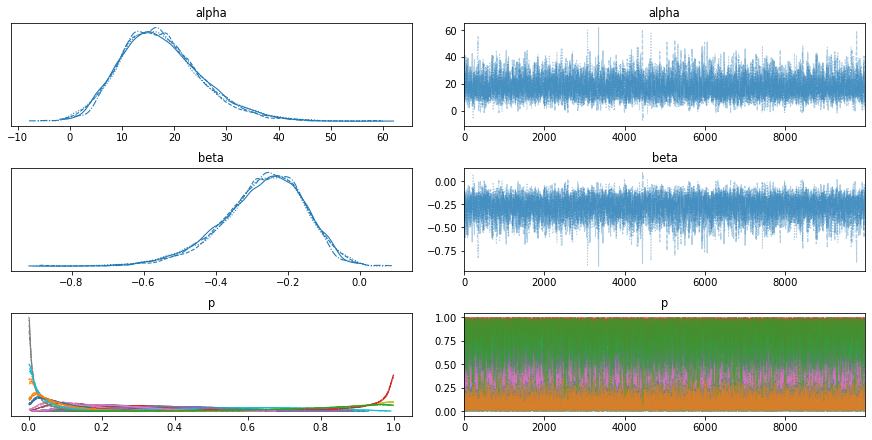

In [14]:
temperature = data[:,0]
D = data[:,1]

with pm.Model() as model:
        # logisticな関数の変数が正規分布から生まれるとする
        alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
        beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
        
        # logisticな分布を定義
        p = pm.Deterministic("p", 1.0/(1. + np.exp(-beta*temperature - alpha)))
        # logistic関数から出てきたパラメータを使うベルヌーイ分布を定義
        D = pm.Bernoulli("D", p=p, observed=D)
        
        # MAP推定を初期値として取得してMCMC開始
        start = pm.find_MAP()
        trace = pm.sample(10000, start=start)

# 学習結果の表示
pm.traceplot(trace)

In [5]:
pm.summary(trace, kind="stats")

/opt/conda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,17.615,8.043,3.330,32.991
beta,-0.271,0.118,-0.505,-0.070
p[0],0.441,0.142,0.184,0.708
p[1],0.225,0.100,0.046,0.403
p[2],0.270,0.108,0.082,0.474
p[3],0.323,0.118,0.113,0.547
p[4],0.380,0.130,0.148,0.627
p[5],0.154,0.087,0.016,0.313
p[6],0.127,0.082,0.007,0.276
p[7],0.225,0.100,0.046,0.403


Text(0.5, 0, 'temperture')

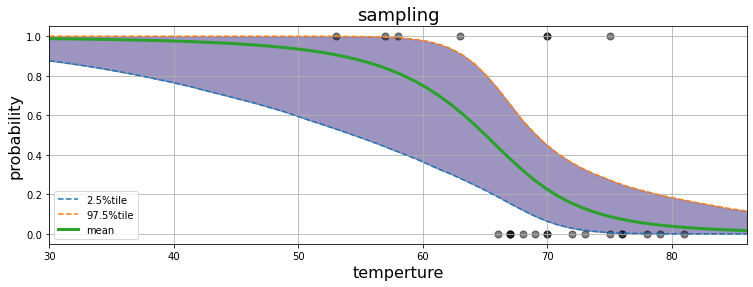

In [7]:
# 視覚化

D = data[:,1]

def logistic(x, alpha, beta):
    y = 1.0/(1. + np.exp(-beta*x - alpha))
    return y

# グラフ用の空間とtempertureに変換する関数を作成
t = np.linspace(30, temperature.max() + 5, 60)[:, None]
p = logistic(t.T, alpha=trace["alpha"][:, None], beta=trace["beta"][:, None], )

# 中央線
mean_p = p.mean(axis=0)

import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles

# quantileデータを取得
qs = mquantiles(p, [0.025, 0.975],axis=0)
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.grid(True)
ax.fill_between(t[:, 0], *qs, alpha=0.7, color="#7468a6")
ax.plot(t, qs[0], ls="--", label="2.5%tile")
ax.plot(t, qs[1], ls="--", label="97.5%tile")
ax.plot(t, mean_p, lw=3, label="mean")
# 実データプロット
ax.scatter(x=temperature, y=D, s=50, color="k", alpha=0.5)

ax.legend(loc="lower left")
ax.set_xlim(t.min(), t.max())
ax.set_title("sampling", fontsize=18)
ax.set_ylabel("probability", fontsize=16)
ax.set_xlabel("temperture", fontsize=16)

In [28]:
# 事故当時のデータで確率を計算
x_temp = 31
p_post = logistic(x_temp, alpha=trace["alpha"][:, None], beta=trace["beta"][:, None], )
qs_post = mquantiles(p_post, [0.25, 0.5, 0.75],axis=0)

np.mean(p_post)

0.98623828679542